In [1]:
from pyscf import gto, scf, fci, mcscf
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider
from math import comb
import time
import numpy as np
from scipy.sparse import csr_matrix


from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
backend = AerSimulator(method = "statevector",noise_model=None)

In [3]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def apply_pauli_string(state, pauli_string):
    """
    state: "010101..." (ket)
    pauli_string: "XIZY..."
    
    Returns:
        (new_state, phase factor)
    """
    state_list = list(state)
    phase = 1.0

    for i, p in enumerate(pauli_string):
        if p == 'I':
            continue
        elif p == 'Z':
            if state[i] == '1':
                phase *= -1
        elif p == 'X':
            # X → flip
            state_list[i] = '1' if state[i] == '0' else '0'
        elif p == 'Y':
            # Y → flip + phase
            if state[i] == '0':
                phase *= 1j
            else:
                phase *= -1j
            state_list[i] = '1' if state[i] == '0' else '0'

    new_state = ''.join(state_list)
    return new_state, phase

def binary_string_to_sparse_state(bitstring):
    """
    binary string (예: '1000') → sparse state vector (CSR matrix)
    """
    n = len(bitstring)
    dim = 2 ** n
    index = int(bitstring, 2)  # binary string → 정수 인덱스

    # 상태벡터: 0으로 초기화 후, 해당 위치만 1
    state = np.zeros((1, dim), dtype=complex)
    state[0, index] = 1.0

    # 희소 행렬로 변환 (row vector 형태)
    sparse_state = csr_matrix(state)
    return sparse_state

'''
def inner_product_pauli_hamiltonian(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    pauli_matrix = pauli_op.to_matrix(sparse=True)
    state_bra = binary_string_to_sparse_state(basis_bra)
    state_ket = binary_string_to_sparse_state(basis_ket)
    y = state_bra @ pauli_matrix            # 1×16
    result = y @ state_ket.getH()
    
    return result[0,0]
'''

def inner_product_pauli_hamiltonian(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    
    
    total = 0.0
    
    # PauliSumOp.to_list() → list of (Pauli string, coeff)
    for pauli_string, coeff in pauli_op.to_list():
        new_state, phase = apply_pauli_string(basis_ket, pauli_string)
        if new_state == basis_bra:
            # term contribute
            total += coeff * phase
    
    return total.real

def project_hamiltonian(basis,hamiltonian):
    n = len(basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis[i]
            basis_ket = basis[j]
            inner_product = inner_product_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 

            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    return H 

def particle_count(s):
    n = len(s)
    half = n // 2
    left = s[:half].count('1')
    right = s[half:].count('1')
    return left, right

def flip_one_pair(s, zero_idx, one_idx):
    """
    문자열 s에서 zero_idx는 '0'이어야 하고 → '1'로 바꾸고,
    one_idx는 '1'이어야 하고 → '0'으로 바꿈
    """
    s = list(s)
    assert s[zero_idx] == '0', f"Index {zero_idx} is not 0"
    assert s[one_idx] == '1', f"Index {one_idx} is not 1"
    s[zero_idx] = '1'
    s[one_idx] = '0'
    return ''.join(s)

def one_step_states_constrained(s):
    """1번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    zeros = [i for i, c in enumerate(s) if c == '0']
    ones = [i for i, c in enumerate(s) if c == '1']
    target_left, target_right = particle_count(s)

    states = set()
    for zi in zeros:
        for oi in ones:
            if zi == oi:
                continue
            new_s = flip_one_pair(s, zi, oi)
            l, r = particle_count(new_s)
            if l == target_left and r == target_right:
                states.add(new_s)
    return states

def two_step_states_constrained(s):
    """2번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    step1 = one_step_states_constrained(s)
    states = set()
    for inter in step1:
        states.update(one_step_states_constrained(inter))
    states.discard(s)  # 자기 자신은 제외
    return states

def calc_total_space(n,k):
    alpha_spin_orbital =int(n/2)
    alpha_electron = int(k/2)
    dim = (comb(alpha_spin_orbital, alpha_electron))**2
    return dim
    

In [4]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    print("num_qubits:" , num_qubits)
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "uccsd":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state,generalized=True)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 uccsd or twolocal ")
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, num_particles):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    time2 = time.time()

    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=5000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]
    print("sampled_space : " , len(probs))

    all_basis = []
    all_prob = []

    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if left_ones+right_ones == np.sum(num_particles):
            all_basis.append(bitstring)
            all_prob.append(prob)
    all_basis = np.array(all_basis)
    #print(len(all_basis))
    all_prob = np.array(all_prob)
        # ... 코드 ...
    
    print("-----------------------")
    print(f"Sampling : {time.time() - time2:.6f}초")
    return all_basis

def construct_c_i(all_basis, C_i_1):
    c_i = all_basis | C_i_1
    return c_i    

def screening(all_basis,hamiltonian,k):
    time2 = time.time()
    screened_space = []
    H = project_hamiltonian(all_basis,hamiltonian)
    print(f"Screening_projection : {time.time() - time2:.6f}초")
    
    time3 = time.time()
    eigenvalue, eigenvector = eigsh(H, k=1, tol=1e-4, which='SA')  # SA: smallest algebraic
    print(f"Screening_Digonalization: {time.time() - time3:.6f}초")

    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    
    #print(important_states)
    for idx in important_states:
        screened_basis = all_basis[idx]
        screened_space.append(screened_basis)
        
    H_sub = H[np.ix_(important_states, important_states)]
    print(f"Screening : {time.time() - time2:.6f}초")
    
    return screened_space,  H_sub


def energy_calc(screened_space,hamiltonian):
    time2 = time.time()
    mat = project_hamiltonian(screened_space,hamiltonian)  
    eigvals, eigvecs = eigsh(mat, k=1, which='SA')
    # 가장 작은 고윳값
    smallest_eigenvalue = eigvals[0]
    smallest_eigvec = eigvecs[0]
    #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
    print(f"energy calc: {time.time() - time2:.6f}초")
    
    return smallest_eigenvalue, smallest_eigvec

def post_screening(smallest_eigvec, screened_space, eps):
    time2 = time.time()
    low_contrib_space = []
    low_contrib_indices = np.where(np.abs(smallest_eigvec) < eps)[0]
    for idx in low_contrib_indices:
        low_contrib_state = screened_space[idx]
        low_contrib_space.append(low_contrib_state)
    post_screened_space = list(set(screened_space) - set(low_contrib_space))
    print(f"post screening: {time.time() - time2:.6f}초")
    return post_screened_space 

def classical_expansion(smallest_eigvec,screened_space,post_screened_space):
    time2 = time.time()
    max_index = np.argmax(np.abs(smallest_eigvec))
    s = screened_space[max_index]
    s1_constrained = one_step_states_constrained(s)
    s2_constrained = two_step_states_constrained(s)
    #print(s1_constrained)
    #print(s2_constrained)
    excitation_expansion = s1_constrained.union(s2_constrained)
    total_expansion = excitation_expansion.union(post_screened_space)    
    print(f"calssical expansion: {time.time() - time2:.6f}초")
    return list(total_expansion), list(excitation_expansion)

In [5]:
class CostWithHistoryList:
    def __init__(self, hamiltonian, ansatz, backend, num_electrons, num_determinant, eps, num_particles,core,repulsion ,threshold=1e-4):

        self.prev_list = []
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.backend = backend
        self.num_electrons = num_electrons
        self.num_determinant = num_determinant
        self.eps = eps
        self.num_particles = num_particles
        self.core =core
        self.repulsion = repulsion
        # 저장소
        self.ith_space = None
        self.expanded_space = None
        self.energy_history = []
        self.iteration = 0
        self.threshold = threshold

        # 수렴 추적용
        self.prev_energies = []
        self.converged_count = 0

    def __call__(self, parameter):
        time2 = time.time()
        current_list = list(self.compute_current_list(parameter))
        self.prev_list = list(set(self.prev_list + current_list))

        # 에너지 계산
        print("Constructed_space",len(self.prev_list))
        
        if len(self.prev_list) > self.num_determinant: 
            screened_space, Hsub = screening(self.prev_list, self.hamiltonian, self.num_determinant)
            print("screened_space",len(screened_space))
            time2 = time.time()
            eigvals, eigvecs = eigsh(Hsub, k=1, which='SA')
            # 가장 작은 고윳값
            Energy = eigvals[0]
            ground_state = eigvecs[0]
            #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
            print(f"energy calc: {time.time() - time2:.6f}초")
        else : 
            screened_space = self.prev_list
            print("screened_space",len(screened_space))
            Energy, ground_state = energy_calc(screened_space, self.hamiltonian)
        
        post_screened_space = post_screening(ground_state, screened_space, self.eps)
        

        # 저장
        self.ith_space, self.expanded_space = classical_expansion(ground_state,screened_space,post_screened_space)
        self.iteration += 1
        self.energy_history.append(Energy)

        # 에너지 변화량 추적
        if self.prev_energies:
            delta = abs(Energy - self.prev_energies[-1])
            if delta < self.threshold:
                self.converged_count += 1
            else:
                self.converged_count = 0

            if self.converged_count >= 3:
        
                print(f"🔚 조기 종료: ΔE < {self.threshold} 가 3회 연속 만족됨.")
                raise StopIteration

        self.prev_energies.append(Energy)

        print(f"each iteration: {time.time() - time2:.6f}초")
        print(f"Iter {self.iteration}: Energy = {Energy +self.repulsion + self.core:.6f}")
        print("-----------------------")
        
        return Energy

    def compute_current_list(self, parameter):
        return sampling_Filtering(self.ansatz, parameter, self.backend, self.num_particles)

In [6]:
def HIVQE(E_problem, k, E_FCI ,which_as = True, fig = True):
    num_spin_orbital = 2*E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    # Transformer 적용
    #E_problem = active_transformer.transform(problem)
    # 여기는 이후, As_transformer 로 변경. 
    fermionic_hamiltonian = E_problem.hamiltonian
    repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
    if which_as == True:
        core = fermionic_hamiltonian.constants['ActiveSpaceTransformer']
    else:
        core = 0
    second_q_op = fermionic_hamiltonian.second_q_op()
    hamiltonian,mapper = fermion_to_qubit(E_problem, second_q_op, "JW")

    time1 = time.time() #헤밀토니안 구성
    # ... 코드 ...
    eps = 10**(-5)
    Chem_accuracy = 0.0016
    ansatz = Circuit_Preperation(hamiltonian, E_problem, mapper, "uccsd")
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    cost_func = CostWithHistoryList(
        hamiltonian=hamiltonian,
        ansatz=ansatz,
        backend=backend,
        num_electrons=num_electrons,
        num_determinant=k,
        eps=eps,
        num_particles = num_particles,
        core = core,
        repulsion= repulsion
    )


    try:
        res = minimize(
            cost_func,
            x0,
            method="cobyla",
            options={"maxiter": 20, "disp": True}
        )
        
    except StopIteration:
        print("⚠️ Optimization stopped early due to convergence criteria.")
        
    if fig == True:   
        if which_as == True:
            plt.plot(cost_func.energy_history+core+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
        else:
            plt.plot(cost_func.energy_history+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
            
        #plt.axhline(E_HF, label = "HF")
        plt.axhline(E_FCI, color ='r',ls= '--',label = "Numpy_minimum_eigensolver")
        plt.ticklabel_format(style='plain', axis='y')  # 과학적 표기 X
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # 일반 숫자 포맷
        plt.gca().ticklabel_format(useOffset=False, style='plain')  # 진짜 값으로
        plt.title("Energy")
        plt.xlabel("Iteration")
        plt.ylabel("Energy(hartree)")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        plt.grid()
        plt.show()
        
        if which_as == True:
            error = cost_func.energy_history + core + repulsion - E_FCI
        else:
            error = cost_func.energy_history  + repulsion - E_FCI    
        for i in range(len(error)) : 
            err = error[i]
            if err < 10**(-7) : 
                error[i]= 10**(-7)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열, 가로 배치

        # 좌측: 일반 스케일 그래프
        axes[0].plot(error, marker='x', linestyle='-', label="HIVQE")
        axes[0].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
        axes[0].set_title("error")
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel("Error (hartree)")
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        axes[0].grid()

        # 우측: 로그 스케일 그래프
        axes[1].plot(error, marker='x', linestyle='-', label="HIVQE")
        axes[1].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
        axes[1].set_yscale("log")
        axes[1].set_title("error (log scale)")
        axes[1].set_xlabel("Iteration")
        axes[1].set_ylabel("Error (hartree) [log scale]")
        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
        axes[1].grid()
    
    energy = cost_func.energy_history[-1] +repulsion + core
    return energy

In [7]:
start = time.time()

atoms = ["H", "H"]
basis = 'sto3g'
dist = 0.735
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1

Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 


num_spin_orbital = 2*E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)

4


In [8]:
mol = gto.Mole()
mol.atom = 'H 0 0 0; H 0 0 0.735'
mol.basis = 'sto-3g'
mol.spin = 0           # (2S), LiH는 closed-shell
mol.charge = 0
mol.build()

# 2. Hartree–Fock 계산 (reference wavefunction)
mf = scf.RHF(mol)
hf_energy = mf.kernel()

E_nuc = mol.energy_nuc()


# 3. FCI 계산
cisolver = fci.FCI(mol, mf.mo_coeff)
E_FCI, fci_vector = cisolver.kernel()
print(f"FCI Energy    = {E_FCI:.8f} Ha")

converged SCF energy = -1.116998996754
FCI Energy    = -1.13730604 Ha


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.103430초
Constructed_space 4
Screening_projection : 0.001439초
Screening_Digonalization: 0.000395초
Screening : 0.001919초
screened_space 3
energy calc: 0.000085초
post screening: 0.000012초
calssical expansion: 0.000032초
each iteration: 0.000151초
Iter 1: Energy = -1.137306
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.043567초
Constructed_space 4
Screening_projection : 0.000992초
Screening_Digonalization: 0.000129초
Screening : 0.001164초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000115초
Iter 2: Energy = -1.137306
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.044648초
Constructed_space 4
Screening_projection : 0.001911초
Screening_Digonalization: 0.000122초
Screening : 0.002073초
screened_space 3
energy calc: 0.000063초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


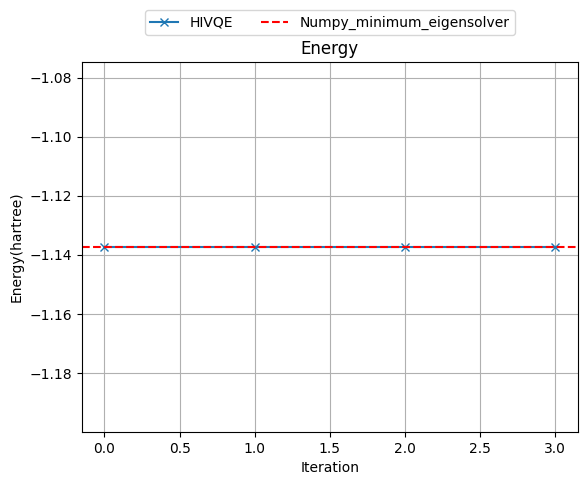

-1.1373060357533995

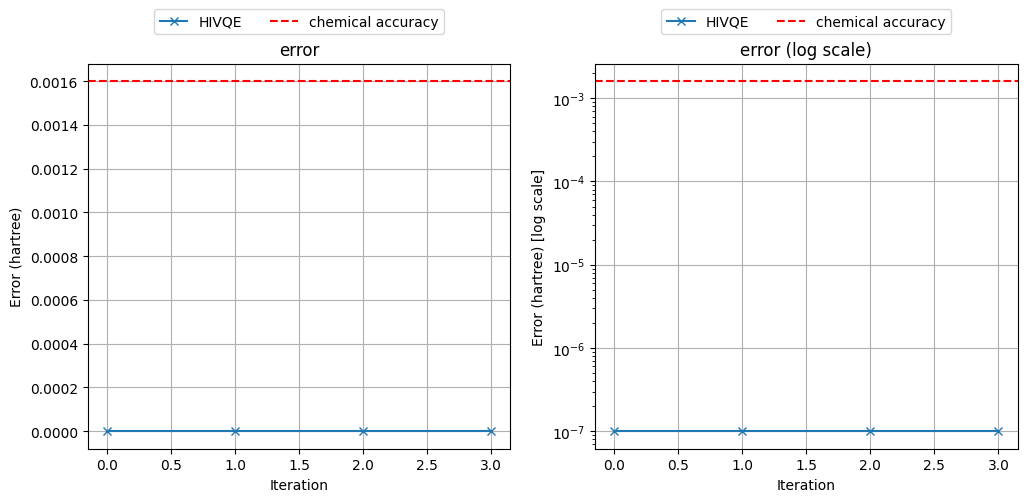

In [9]:
HIVQE(E_problem, 3, E_FCI, False, True)

num_qubits: 4
sampled_space :  3
-----------------------
Sampling : 0.039534초
Constructed_space 3
screened_space 3
energy calc: 0.000695초
post screening: 0.000008초
calssical expansion: 0.000023초
each iteration: 0.040315초
Iter 1: Energy = -0.601804
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041864초
Constructed_space 4
Screening_projection : 0.000956초
Screening_Digonalization: 0.000115초
Screening : 0.001104초
screened_space 3
energy calc: 0.000059초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000106초
Iter 2: Energy = -0.601804
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041465초
Constructed_space 4
Screening_projection : 0.000981초
Screening_Digonalization: 0.000122초
Screening : 0.001138초
screened_space 3
energy calc: 0.000060초
post screening: 0.000007초
calssical expansion: 0.000023초
each iteration: 0.000109초
Iter 3: Energy = -0.601804
-----------------------
sampled_space :  2
-----------

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.041540초
Constructed_space 4
Screening_projection : 0.000964초
Screening_Digonalization: 0.000117초
Screening : 0.001115초
screened_space 3
energy calc: 0.000058초
post screening: 0.000006초
calssical expansion: 0.000024초
each iteration: 0.000105초
Iter 1: Energy = -0.870041
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.043960초
Constructed_space 4
Screening_projection : 0.000998초
Screening_Digonalization: 0.000122초
Screening : 0.001155초
screened_space 3
energy calc: 0.000060초
post screening: 0.000007초
calssical expansion: 0.000024초
each iteration: 0.000111초
Iter 2: Energy = -0.870041
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042187초
Constructed_space 4
Screening_projection : 0.001388초
Screening_Digonalization: 0.000121초
Screening : 0.001553초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000023초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.043593초
Constructed_space 4
Screening_projection : 0.000963초
Screening_Digonalization: 0.000117초
Screening : 0.001113초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000104초
Iter 1: Energy = -1.011649
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041391초
Constructed_space 4
Screening_projection : 0.000949초
Screening_Digonalization: 0.000110초
Screening : 0.001091초
screened_space 3
energy calc: 0.000057초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000103초
Iter 2: Energy = -1.011649
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042655초
Constructed_space 4
Screening_projection : 0.000967초
Screening_Digonalization: 0.000120초
Screening : 0.001120초
screened_space 3
energy calc: 0.000060초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044545초
Constructed_space 4
Screening_projection : 0.000996초
Screening_Digonalization: 0.000121초
Screening : 0.001152초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000023초
each iteration: 0.000108초
Iter 1: Energy = -1.086386
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042090초
Constructed_space 4
Screening_projection : 0.000954초
Screening_Digonalization: 0.000111초
Screening : 0.001096초
screened_space 3
energy calc: 0.000057초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000104초
Iter 2: Energy = -1.086386
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041387초
Constructed_space 4
Screening_projection : 0.000952초
Screening_Digonalization: 0.000113초
Screening : 0.001096초
screened_space 3
energy calc: 0.000056초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.042754초
Constructed_space 4
Screening_projection : 0.000972초
Screening_Digonalization: 0.000122초
Screening : 0.001129초
screened_space 3
energy calc: 0.000059초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000106초
Iter 1: Energy = -1.122767
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042073초
Constructed_space 4
Screening_projection : 0.000958초
Screening_Digonalization: 0.000118초
Screening : 0.001109초
screened_space 3
energy calc: 0.000057초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000104초
Iter 2: Energy = -1.122767
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041683초
Constructed_space 4
Screening_projection : 0.000954초
Screening_Digonalization: 0.000115초
Screening : 0.001102초
screened_space 3
energy calc: 0.000056초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.048653초
Constructed_space 4
Screening_projection : 0.000987초
Screening_Digonalization: 0.000120초
Screening : 0.001142초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000105초
Iter 1: Energy = -1.136189
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.045608초
Constructed_space 4
Screening_projection : 0.001053초
Screening_Digonalization: 0.000134초
Screening : 0.001282초
screened_space 3
energy calc: 0.000129초
post screening: 0.000010초
calssical expansion: 0.000024초
each iteration: 0.000193초
Iter 2: Energy = -1.136189
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.049659초
Constructed_space 4
Screening_projection : 0.001001초
Screening_Digonalization: 0.000132초
Screening : 0.001168초
screened_space 3
energy calc: 0.000059초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.041343초
Constructed_space 4
Screening_projection : 0.000968초
Screening_Digonalization: 0.000118초
Screening : 0.001118초
screened_space 3
energy calc: 0.000057초
post screening: 0.000006초
calssical expansion: 0.000023초
each iteration: 0.000103초
Iter 1: Energy = -1.135727
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041519초
Constructed_space 4
Screening_projection : 0.000970초
Screening_Digonalization: 0.000116초
Screening : 0.001118초
screened_space 3
energy calc: 0.000059초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000106초
Iter 2: Energy = -1.135727
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041205초
Constructed_space 4
Screening_projection : 0.000980초
Screening_Digonalization: 0.000123초
Screening : 0.001137초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.044377초
Constructed_space 4
Screening_projection : 0.001617초
Screening_Digonalization: 0.000121초
Screening : 0.001776초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -1.10055080623256
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044109초
Constructed_space 4
Screening_projection : 0.000976초
Screening_Digonalization: 0.000119초
Screening : 0.001128초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000103초
Iter 1: Energy = -1.113274
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041890초
Constructed_space 4
Screening_projection : 0.000962초
Screening_Digonalization: 0.000118초
Screening : 0.001112초
screened_space 3
energy calc: 0.000056초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.044310초
Constructed_space 4
Screening_projection : 0.001814초
Screening_Digonalization: 0.000131초
Screening : 0.001995초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000024초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -1.08220447580839
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.042312초
Constructed_space 4
Screening_projection : 0.000966초
Screening_Digonalization: 0.000119초
Screening : 0.001118초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000106초
Iter 1: Energy = -1.096884
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041038초
Constructed_space 4
Screening_projection : 0.000970초
Screening_Digonalization: 0.000114초
Screening : 0.001116초
screened_space 3
energy calc: 0.000058초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.042165초
Constructed_space 4
Screening_projection : 0.002604초
Screening_Digonalization: 0.000123초
Screening : 0.002774초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000024초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -1.06042300594045
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.041611초
Constructed_space 4
Screening_projection : 0.000940초
Screening_Digonalization: 0.000120초
Screening : 0.001093초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000103초
Iter 1: Energy = -1.079193
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041867초
Constructed_space 4
Screening_projection : 0.001060초
Screening_Digonalization: 0.000124초
Screening : 0.001266초
screened_space 3
energy calc: 0.000059초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.040815초
Constructed_space 4
Screening_projection : 0.001669초
Screening_Digonalization: 0.000446초
Screening : 0.002154초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000023초
each iteration: 0.000117초
Iter 3: Energy = -1.079193
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.045133초
Constructed_space 4
Screening_projection : 0.000979초
Screening_Digonalization: 0.000119초
Screening : 0.001131초
screened_space 3
energy calc: 0.000057초
post screening: 0.000007초
calssical expansion: 0.000021초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -1.03653887502918
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.041664초
Constructed_space 4
Screening_projection : 0.000939초
Screening_Digonalization: 0.000121초
Screening : 0.001093초
screened_space 3
energy calc: 0.000057초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.042503초
Constructed_space 4
Screening_projection : 0.001813초
Screening_Digonalization: 0.000253초
Screening : 0.002108초
screened_space 3
energy calc: 0.000060초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000109초
Iter 3: Energy = -1.061197
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.044177초
Constructed_space 4
Screening_projection : 0.000958초
Screening_Digonalization: 0.000117초
Screening : 0.001108초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000021초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -1.0114736465476
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.045003초
Constructed_space 4
Screening_projection : 0.001079초
Screening_Digonalization: 0.000123초
Screening : 0.001242초
screened_space 3
energy calc: 0.000057초
post screening: 0

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.043465초
Constructed_space 4
Screening_projection : 0.002782초
Screening_Digonalization: 0.000269초
Screening : 0.003103초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000023초
each iteration: 0.000109초
Iter 3: Energy = -1.043631
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.045473초
Constructed_space 4
Screening_projection : 0.000958초
Screening_Digonalization: 0.000119초
Screening : 0.001111초
screened_space 3
energy calc: 0.000057초
post screening: 0.000008초
calssical expansion: 0.000021초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.98591034539906
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.042309초
Constructed_space 4
Screening_projection : 0.000959초
Screening_Digonalization: 0.000120초
Screening : 0.001112초
screened_space 3
energy calc: 0.000057초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.044083초
Constructed_space 4
Screening_projection : 0.002108초
Screening_Digonalization: 0.000273초
Screening : 0.002429초
screened_space 3
energy calc: 0.000070초
post screening: 0.000009초
calssical expansion: 0.000022초
each iteration: 0.000120초
Iter 3: Energy = -1.027039
-----------------------
sampled_space :  3
-----------------------
Sampling : 0.046456초
Constructed_space 4
Screening_projection : 0.001857초
Screening_Digonalization: 0.000130초
Screening : 0.002033초
screened_space 3
energy calc: 0.000060초
post screening: 0.000010초
calssical expansion: 0.000028초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.960372494913136
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044647초
Constructed_space 4
Screening_projection : 0.000969초
Screening_Digonalization: 0.000121초
Screening : 0.001123초
screened_space 3
energy calc: 0.000057초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047133초
Constructed_space 4
Screening_projection : 0.001800초
Screening_Digonalization: 0.000246초
Screening : 0.002092초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000023초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.935260492617246
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.041477초
Constructed_space 4
Screening_projection : 0.000958초
Screening_Digonalization: 0.000116초
Screening : 0.001108초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000021초
each iteration: 0.000104초
Iter 1: Energy = -0.998149
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041964초
Constructed_space 4
Screening_projection : 0.000972초
Screening_Digonalization: 0.000110초
Screening : 0.001115초
screened_space 3
energy calc: 0.000057초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.043979초
Constructed_space 4
Screening_projection : 0.001890초
Screening_Digonalization: 0.000241초
Screening : 0.002171초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000023초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.910873554594386
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.042319초
Constructed_space 4
Screening_projection : 0.000947초
Screening_Digonalization: 0.000118초
Screening : 0.001096초
screened_space 3
energy calc: 0.000059초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000105초
Iter 1: Energy = -0.986194
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042040초
Constructed_space 4
Screening_projection : 0.000943초
Screening_Digonalization: 0.000126초
Screening : 0.001103초
screened_space 3
energy calc: 0.000057초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.109897초
Constructed_space 4
Screening_projection : 0.002072초
Screening_Digonalization: 0.000324초
Screening : 0.002448초
screened_space 3
energy calc: 0.000067초
post screening: 0.000009초
calssical expansion: 0.000023초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.887427960052492
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.046062초
Constructed_space 4
Screening_projection : 0.002200초
Screening_Digonalization: 0.000256초
Screening : 0.002504초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000021초
each iteration: 0.000114초
Iter 1: Energy = -0.975939
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.043676초
Constructed_space 4
Screening_projection : 0.000981초
Screening_Digonalization: 0.000123초
Screening : 0.001136초
screened_space 3
energy calc: 0.000059초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.045681초
Constructed_space 4
Screening_projection : 0.001443초
Screening_Digonalization: 0.000119초
Screening : 0.001601초
screened_space 3
energy calc: 0.000057초
post screening: 0.000008초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.86507351562771
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.043973초
Constructed_space 4
Screening_projection : 0.001883초
Screening_Digonalization: 0.000257초
Screening : 0.002181초
screened_space 3
energy calc: 0.000066초
post screening: 0.000007초
calssical expansion: 0.000021초
each iteration: 0.000113초
Iter 1: Energy = -0.967306
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042124초
Constructed_space 4
Screening_projection : 0.001073초
Screening_Digonalization: 0.000123초
Screening : 0.001235초
screened_space 3
energy calc: 0.000058초
post screening: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047285초
Constructed_space 4
Screening_projection : 0.001688초
Screening_Digonalization: 0.000232초
Screening : 0.001961초
screened_space 3
energy calc: 0.000061초
post screening: 0.000007초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.843907591197447
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.045813초
Constructed_space 4
Screening_projection : 0.001490초
Screening_Digonalization: 0.000119초
Screening : 0.001644초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000107초
Iter 1: Energy = -0.960162
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.069342초
Constructed_space 4
Screening_projection : 0.001373초
Screening_Digonalization: 0.000133초
Screening : 0.001557초
screened_space 3
energy calc: 0.000059초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  3
-----------------------
Sampling : 0.049244초
Constructed_space 4
Screening_projection : 0.002930초
Screening_Digonalization: 0.000281초
Screening : 0.003296초
screened_space 3
energy calc: 0.000240초
post screening: 0.000021초
calssical expansion: 0.000060초
each iteration: 0.000378초
Iter 3: Energy = -0.960162
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.046654초
Constructed_space 4
Screening_projection : 0.001910초
Screening_Digonalization: 0.000336초
Screening : 0.002300초
screened_space 3
energy calc: 0.000067초
post screening: 0.000009초
calssical expansion: 0.000025초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.823986264782553
num_qubits: 4
sampled_space :  3
-----------------------
Sampling : 0.042253초
Constructed_space 3
screened_space 3
energy calc: 0.000674초
post screening: 0.000008초
calssical expansion: 0.000021초
each iteration: 0.043011초
Iter 1: Energy = -0.954

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.045124초
Constructed_space 4
Screening_projection : 0.001794초
Screening_Digonalization: 0.000252초
Screening : 0.002087초
screened_space 3
energy calc: 0.000066초
post screening: 0.000010초
calssical expansion: 0.000021초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.805332844893277
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.043042초
Constructed_space 4
Screening_projection : 0.001075초
Screening_Digonalization: 0.000122초
Screening : 0.001236초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000106초
Iter 1: Energy = -0.949655
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.042802초
Constructed_space 4
Screening_projection : 0.000953초
Screening_Digonalization: 0.000115초
Screening : 0.001101초
screened_space 3
energy calc: 0.000058초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047478초
Constructed_space 4
Screening_projection : 0.001482초
Screening_Digonalization: 0.000116초
Screening : 0.001636초
screened_space 3
energy calc: 0.000057초
post screening: 0.000007초
calssical expansion: 0.000021초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.787944468139425
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044426초
Constructed_space 4
Screening_projection : 0.000959초
Screening_Digonalization: 0.000121초
Screening : 0.001114초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000104초
Iter 1: Energy = -0.945931
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.041838초
Constructed_space 4
Screening_projection : 0.000961초
Screening_Digonalization: 0.000115초
Screening : 0.001108초
screened_space 3
energy calc: 0.000059초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047485초
Constructed_space 4
Screening_projection : 0.001874초
Screening_Digonalization: 0.000116초
Screening : 0.002028초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000020초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.771797500520221
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.047492초
Constructed_space 4
Screening_projection : 0.000998초
Screening_Digonalization: 0.000126초
Screening : 0.001160초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000107초
Iter 1: Energy = -0.942997
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.046857초
Constructed_space 4
Screening_projection : 0.000968초
Screening_Digonalization: 0.000127초
Screening : 0.001130초
screened_space 3
energy calc: 0.000058초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.051701초
Constructed_space 4
Screening_projection : 0.001823초
Screening_Digonalization: 0.000281초
Screening : 0.002153초
screened_space 3
energy calc: 0.000062초
post screening: 0.000009초
calssical expansion: 0.000023초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.756852260585157
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.042900초
Constructed_space 4
Screening_projection : 0.000950초
Screening_Digonalization: 0.000115초
Screening : 0.001099초
screened_space 3
energy calc: 0.000058초
post screening: 0.000006초
calssical expansion: 0.000021초
each iteration: 0.000104초
Iter 1: Energy = -0.940703
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.044743초
Constructed_space 4
Screening_projection : 0.000969초
Screening_Digonalization: 0.000120초
Screening : 0.001121초
screened_space 3
energy calc: 0.000058초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047726초
Constructed_space 4
Screening_projection : 0.002148초
Screening_Digonalization: 0.000252초
Screening : 0.002453초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.743057308180639
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.043073초
Constructed_space 4
Screening_projection : 0.001181초
Screening_Digonalization: 0.000118초
Screening : 0.001337초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000105초
Iter 1: Energy = -0.938922
-----------------------
sampled_space :  3
-----------------------
Sampling : 0.042107초
Constructed_space 4
Screening_projection : 0.000957초
Screening_Digonalization: 0.000113초
Screening : 0.001100초
screened_space 3
energy calc: 0.000057초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.047279초
Constructed_space 4
Screening_projection : 0.001667초
Screening_Digonalization: 0.000256초
Screening : 0.001971초
screened_space 3
energy calc: 0.000066초
post screening: 0.000008초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.730353321354887
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044569초
Constructed_space 4
Screening_projection : 0.001069초
Screening_Digonalization: 0.000118초
Screening : 0.001233초
screened_space 3
energy calc: 0.000058초
post screening: 0.000007초
calssical expansion: 0.000022초
each iteration: 0.000105초
Iter 1: Energy = -0.937546
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.044460초
Constructed_space 4
Screening_projection : 0.000950초
Screening_Digonalization: 0.000110초
Screening : 0.001091초
screened_space 3
energy calc: 0.000056초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  4
-----------------------
Sampling : 0.056329초
Constructed_space 4
Screening_projection : 0.001763초
Screening_Digonalization: 0.000254초
Screening : 0.002057초
screened_space 3
energy calc: 0.000059초
post screening: 0.000008초
calssical expansion: 0.000023초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.718676465889296
num_qubits: 4
sampled_space :  4
-----------------------
Sampling : 0.044398초
Constructed_space 4
Screening_projection : 0.000997초
Screening_Digonalization: 0.000122초
Screening : 0.001152초
screened_space 3
energy calc: 0.000057초
post screening: 0.000008초
calssical expansion: 0.000022초
each iteration: 0.000104초
Iter 1: Energy = -0.936488
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.043170초
Constructed_space 4
Screening_projection : 0.001027초
Screening_Digonalization: 0.000124초
Screening : 0.001190초
screened_space 3
energy calc: 0.000059초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


sampled_space :  3
-----------------------
Sampling : 0.047222초
Constructed_space 4
Screening_projection : 0.001463초
Screening_Digonalization: 0.000118초
Screening : 0.001620초
screened_space 3
energy calc: 0.000058초
post screening: 0.000008초
calssical expansion: 0.000022초
🔚 조기 종료: ΔE < 0.0001 가 3회 연속 만족됨.
⚠️ Optimization stopped early due to convergence criteria.
converged SCF energy = -0.707961144287678


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


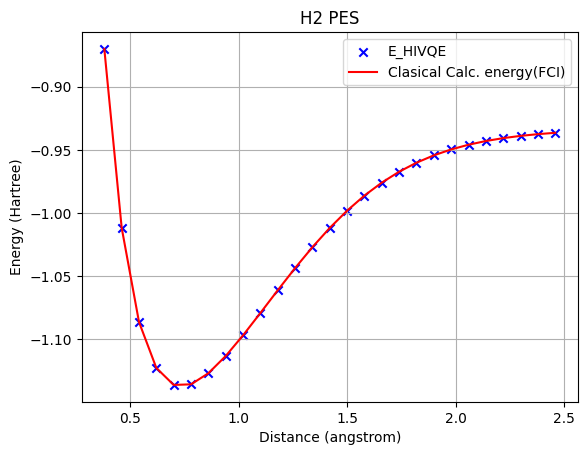

In [11]:
def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'H 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

    # 4. 결과 출력
    #print(f"Hartree–Fock Energy: {hf_energy:.10f} Hartree")
    #print(f"FCI Ground State Energy: {fci_energy:.10f} Hartree")



x = np.arange(0.3, 2.5, 0.08)
E_VQE = []
E_FCI = []
for dist in x:
    atoms = ["H", "H"]
    basis = 'sto3g'
    coords = [(0,0,0), (dist,0,0)]
    charge = 0
    multiplicity = 1

    Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
    driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
    E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 
    e_vqe = HIVQE(E_problem, 3, E_FCI, False, False)
    e_fci = FCI(dist)

    E_VQE.append(e_vqe)
    E_FCI.append(e_fci)



plt.scatter(x[1:], E_VQE[1:], marker='x',color='blue', label="E_HIVQE")
plt.plot(x[1:], E_FCI[1:], color='red', label="Clasical Calc. energy(FCI)")

plt.xlabel("Distance (angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.title("H2 PES")
plt.grid()
plt.show()